# Lab2 Implement and train a Transformer for sentiment analysis
In this lab, we focus on Transformer models. You goal is to reach at least 80% validation and testing
accuracy on the IMDB dataset within at most 10 epochs.

## Set up the environment

In [ ]:
!pip install nltk

In [ ]:
import functools
import sys
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from transformer import TransformerEncoder
from transformer import TransformerEncoder_v

from torch.utils.data import Dataset
import nltk
nltk.download('stopwords')
import copy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Before start


In [ ]:
class IMDB(Dataset):
    def __init__(self, x, y, tokenizer, max_length=256) -> None:
        """
        :param split: can be either "train", "val" or "test".
        :param tokenizer: a simple tokenizer object.
        """
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx: int):
        # tokenize for question(c)
        if USE_PRETRAINED_TOKENIZER:

            
            token_ids =tokenizer.encode(self.x[idx])

        else:
            token_ids = tokenize(self.tokenizer, self.x[idx])

        if self.max_length:

            token_ids = token_ids[:self.max_length]

        label = 1 if self.y[idx] == 'positive' else 0
        return {"ids": token_ids, "length": len(token_ids), "label": label}
           
        #your code here

    def __len__(self) -> int:
        return len(self.x)

In order to run your transformer, please copy your load_imdb function, build_vocab function, tokenize function in lab1 here

In [ ]:
# Your load_imdb here:
def load_imdb(base_csv:str = './IMDBDataset.csv'):
    """
    Load the IMDB dataset
    :param base_csv: the path of the dataset file.
    :return: train, validation and test set.
    """
    # Add your code here.
    df=pd.read_csv('./IMDBDataset.csv',header=None)
    df_con = df[0].loc[1:]
    df_lab = df[1].loc[1:]
    df_con =np.array(df_con)
    df_lab =np.array(df_lab)
    train_X,x_test,train_y,y_test = train_test_split(df_con,df_lab,test_size=0.2)
    x_train,x_valid,y_train,y_valid =train_test_split(train_X,train_y,test_size=0.125)

   
    print(f'shape of train data is {x_train.shape}')
    print(f'shape of test data is {x_test.shape}')
    print(f'shape of valid data is {x_valid.shape}')
    x_train.tolist()
    y_train.tolist()
    x_valid.tolist()
    y_valid.tolist()
    x_test.tolist()
    y_test.tolist()
    return x_train, x_valid, x_test, y_train, y_valid, y_test

# Your build_vocab here:
def build_vocab(x_train:list, min_freq:int = 5) -> dict:
    """
    build a vocabulary based on the training corpus.
    :param x_train:  List. The training corpus. Each sample in the list is a string of text.
    :param min_freq: Int. The frequency threshold for selecting words.
    :return: dictionary {word:index}
    """
    # Add your code here. Your code should assign corpus with a list of words.
    counter=Counter()


    for example in tqdm.tqdm(x_train, total = len(x_train)):
        s = ''.join(example).replace('.','').replace('?','').replace('/','').replace('<br','').replace('>','').replace('\'','').replace('\"','').replace('(','').replace(')','').replace('*','').replace(':','').replace(',','').replace(';','').replace('!','')
        s=s.lower()
        wordList = s.split()
        counter.update(wordList)
    for word in STOP_WORDS:
      try:
          counter.pop(word)
          counter.pop('-')
          counter.pop('&')
          counter.pop('--')
      except:
          continue

    counter2 = copy.deepcopy(counter)
    for item in counter:

      if counter[item] < min_freq:
        counter2.pop(item)
    corpus = [key for key, _ in counter2.most_common()]
    
    # Assign token index to each word in the vocabulary.
    vocab = {w:i+2 for i, w in enumerate(corpus)}
    vocab[PAD_TOKEN] = PAD_INDEX
    vocab[UNK_TOKEN] = UNK_INDEX

    return vocab

# Your tokenize function here
def tokenize(vocab: dict, example: str)-> list:
    """
    Tokenize the give example string into a list of token indices.
    :param vocab: dict, the vocabulary.
    :param example: a string of text.
    :return: a list of token indices.
    """

    counter=Counter()
    s = ''.join(example).replace('.','').replace('?','').replace('/','').replace('<br','').replace('>','').replace('\'','').replace('\"','').replace('(','').replace(')','').replace('*','').replace(':','').replace(',','').replace(';','').replace('!','')
    s=s.lower()
    wordList = s.split()
    for word in STOP_WORDS:
        try:
            wordList.remove(word)
            wordList.remove('-')
            wordList.remove('&')
            wordList.remove('--')
        except:
            continue
    output=[]
    for item in wordList:
        if item in vocab.keys():
            output.append(vocab[item])



        

    return output



In [ ]:
# Constance hyperparameters. They have been tested and don't need to be tuned.
USE_PRETRAINED_TOKENIZER = False
PAD_INDEX = 0
UNK_INDEX = 1
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
BATCH_SIZE = 16
MAX_LENGTH = 256
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 3
ATTN_HEADS = 4
DROPOUT_RATE = 0.1
LR = 3e-4
N_EPOCHS = 5
STOP_WORDS = set(stopwords.words('english'))

In [ ]:
def collate(batch, pad_index):
    batch_ids = [torch.LongTensor(i['ids']) for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = torch.LongTensor([i['label'] for i in batch])
    batch = {'ids': batch_ids, 'label': batch_label}
    return batch


## Q(a)Implement Transformer’s multi-head attention mechanism. 
Open the attention.py file
and implement the class calledMultiHeadedAttention. Use the layers initialized in the __init__
function. Compute attention between query and key. Apply the obtained attention scores on
value. Take care of the multi-head machenism. Apply a fc layer to the output before return.
The transformer.py notebook calls the MultiHeadedAttention module in the attention.
py notebook to establish a Transformer model. Then the lab2.ipynb notebook calls the
Transformer model when initializing the model for sentiment analysis.<br>

Write your code in the attention.py 

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.hidden
        self.fc = nn.Linear(hidden_dim, output_dim)

        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        """
        :param ids: [batch size, seq len]
        :return: prediction of size [batch size, output dim]
        """
        output = self.transformer(ids)
        cls_hidden = output[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs


def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy


## Q(b) Train your model!
Train themodel for 5 epochs. Copy the plotted figures of training/validation loss/accuracy
to your self-contained pdf report. What is your testing accuracy? What is your model size? (The
provided code contains the plot function and computation of test accuracy. You just need to
report the value of testing accuracy.)

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)


100%|██████████| 35000/35000 [00:03<00:00, 9146.70it/s]


Length of vocabulary is 36595
The model has 11,738,882 trainable parameters
evaluating...: 100%|██████████| 313/313 [00:13<00:00, 23.45it/s]
epoch: 1
train_loss: 0.572, train_acc: 0.688
valid_loss: 0.493, valid_acc: 0.765
evaluating...: 100%|██████████| 313/313 [00:13<00:00, 23.50it/s]
epoch: 2
train_loss: 0.441, train_acc: 0.797
valid_loss: 0.433, valid_acc: 0.811
evaluating...: 100%|██████████| 313/313 [00:13<00:00, 23.55it/s]
epoch: 3
train_loss: 0.375, train_acc: 0.836
valid_loss: 0.441, valid_acc: 0.810
evaluating...: 100%|██████████| 313/313 [00:13<00:00, 23.56it/s]
epoch: 4
train_loss: 0.341, train_acc: 0.853
valid_loss: 0.400, valid_acc: 0.834
evaluating...: 100%|██████████| 313/313 [00:13<00:00, 23.48it/s]
epoch: 5
train_loss: 0.295, train_acc: 0.879
valid_loss: 0.352, valid_acc: 0.853
evaluating...: 100%|██████████| 625/625 [00:26<00:00, 23.22it/s]
test_loss: 0.338, test_acc: 0.856
(0, 0.9858296513557434)
(0, 0.9858296513557434)
(0, 0.988572359085083)
(0, 0.988572359085083)


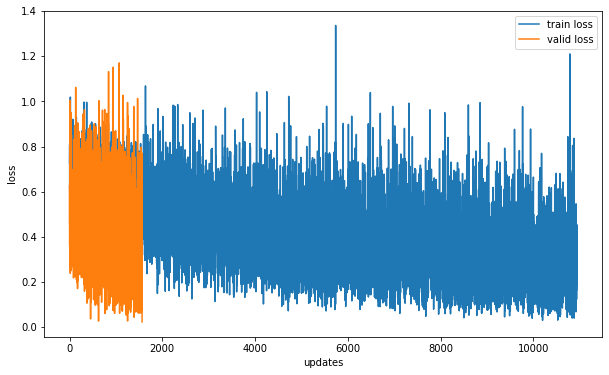

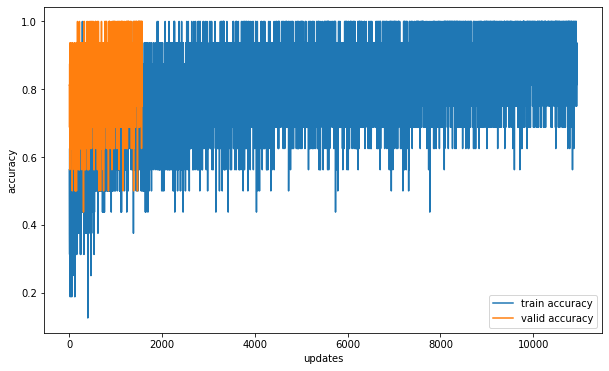

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

if USE_PRETRAINED_TOKENIZER:
    #Your code here for Q(c)
    pass
else:
    tokenizer = build_vocab(x_train)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH)
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH)

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Model
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, OUTPUT_DIM, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')

model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')


def predict_sentiment(text, model, tokenizer, device):
    if USE_PRETRAINED_TOKENIZER:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]
    else:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not terrible, it's great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not great, it's terrible!"
print(predict_sentiment(text, model, tokenizer, device))


## Q(c) Pre-trained tokenizer Usage
Up until now, you have been using your own implemented vocabulary and the provide
tokenization function. What if you want to use a tokenizer of a pre-trained model such as BERT?
Please replace your the vocabulary and tokenizer with
transformers:AutoT okenizer:frompretrained(transformer_name) where
transformer_name ='bert-base-uncased'. Note that this will/should not load the pre-trained
BERT model but just the tokenizer (which implements the WordPiece algorithm).<br>
**Hint:** First you need to set USE_PRETRAINED_TOKENIZER = True, then define your pretrained tokenizer in the training script, make sure your IMDB class get-item function and also predict_sentiment could support pre-trained tokenizer. Please do not remove other code, write your code like if USE_PRETRAINED_TOKENIZER:..., else:...

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 31.4 MB/s 
     |████████████████████████████████| 636 kB 43.4 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
USE_PRETRAINED_TOKENIZER = True
from transformers import BertTokenizer
from transformers import BertModel
model_name = 'bert-base-uncased'
MODEL_PATH = './Transformer-Bert/bert-base-english/'

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 30522
The model has 10,184,194 trainable parameters
training...:   0%|          | 0/2188 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (872 > 512). Running this sequence through the model will result in indexing errors


evaluating...: 100%|██████████| 313/313 [00:46<00:00,  6.67it/s]
epoch: 1
train_loss: 0.655, train_acc: 0.607
valid_loss: 0.622, valid_acc: 0.659
evaluating...: 100%|██████████| 313/313 [00:46<00:00,  6.73it/s]
epoch: 2
train_loss: 0.589, train_acc: 0.693
valid_loss: 0.565, valid_acc: 0.714
evaluating...: 100%|██████████| 313/313 [00:45<00:00,  6.81it/s]
epoch: 3
train_loss: 0.529, train_acc: 0.740
valid_loss: 0.489, valid_acc: 0.774
evaluating...: 100%|██████████| 313/313 [00:46<00:00,  6.71it/s]
epoch: 4
train_loss: 0.475, train_acc: 0.775
valid_loss: 0.458, valid_acc: 0.788
evaluating...: 100%|██████████| 313/313 [00:46<00:00,  6.75it/s]
epoch: 5
train_loss: 0.455, train_acc: 0.791
valid_loss: 0.467, valid_acc: 0.788
evaluating...: 100%|██████████| 625/625 [01:32<00:00,  6.72it/s]
test_loss: 0.464, test_acc: 0.782


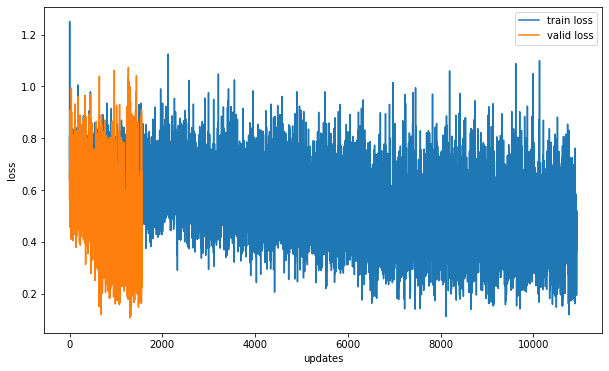

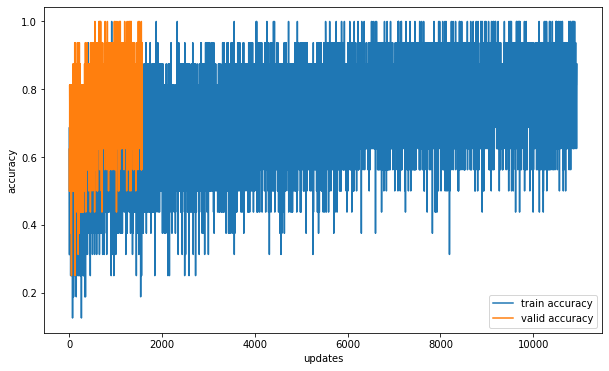

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

if USE_PRETRAINED_TOKENIZER:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

else:
    tokenizer = build_vocab(x_train)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH)
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH)

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Model
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, OUTPUT_DIM, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')

model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')





In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    if USE_PRETRAINED_TOKENIZER:
        token_ids =tokenizer.encode(text)
        ids =  token_ids
    else:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not terrible, it's great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not great, it's terrible!"
print(predict_sentiment(text, model, tokenizer, device))

(0, 0.9596968293190002)
(1, 0.9751595258712769)
(0, 0.9705408811569214)
(1, 0.683830738067627)


## Q(d) Train your model
Train themodel for 5 epochs. Copy the plotted figures of training/validation loss/accuracy
to your self-contained pdf report. What is your testing accuracy? What is your model size? What
do you observe when comparing this with the original model’s performance? (The provided code
contains the plot function and computation of test accuracy. You just need to report the value of
testing accuracy.)

## Q(e) Trainalbe positional embedding
Replace the current PositionalEmbedding with a trainable one. Currently, the PositionalEmbedding
uses the sin and cos function to initialize the positional embedding. These functions are deterministic.
Could you change the class to use trainable neural network to initialize the position
embeddings. For example, you can use the same embedding layer as the token embedding layer.Write your code in the transformer.py

In [ ]:
from transformer import TransformerEncoder

shape of train data is (35000,)
shape of test data is (10000,)
shape of valid data is (5000,)
Length of vocabulary is 30522
The model has 10,184,194 trainable parameters
training...:   0%|          | 0/2188 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (649 > 512). Running this sequence through the model will result in indexing errors


evaluating...: 100%|██████████| 313/313 [00:47<00:00,  6.66it/s]
epoch: 1
train_loss: 0.597, train_acc: 0.663
valid_loss: 0.508, valid_acc: 0.748
evaluating...: 100%|██████████| 313/313 [00:47<00:00,  6.61it/s]
epoch: 2
train_loss: 0.491, train_acc: 0.764
valid_loss: 0.457, valid_acc: 0.790
evaluating...: 100%|██████████| 313/313 [00:47<00:00,  6.62it/s]
epoch: 3
train_loss: 0.434, train_acc: 0.802
valid_loss: 0.451, valid_acc: 0.813
evaluating...: 100%|██████████| 313/313 [00:46<00:00,  6.67it/s]
epoch: 4
train_loss: 0.393, train_acc: 0.825
valid_loss: 0.411, valid_acc: 0.830
evaluating...: 100%|██████████| 313/313 [00:47<00:00,  6.64it/s]
epoch: 5
train_loss: 0.367, train_acc: 0.842
valid_loss: 0.397, valid_acc: 0.834
evaluating...: 100%|██████████| 625/625 [01:34<00:00,  6.65it/s]
test_loss: 0.394, test_acc: 0.834


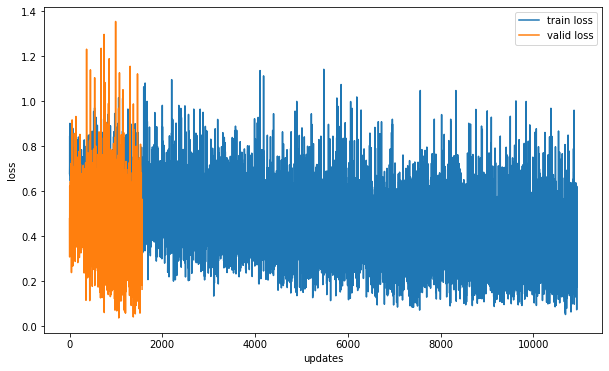

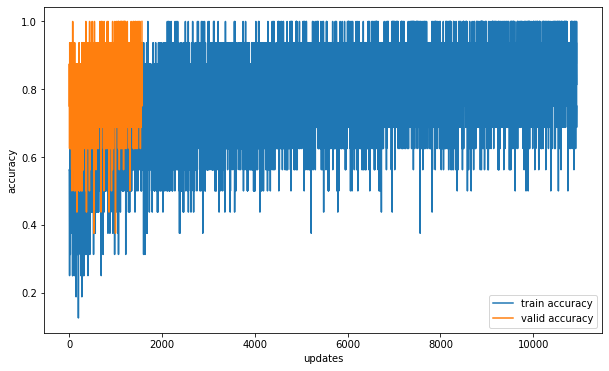

In [ ]:

x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

if USE_PRETRAINED_TOKENIZER:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

else:
    tokenizer = build_vocab(x_train)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH)
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH)

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Model

transformer = TransformerEncoder(vocab_size, hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, OUTPUT_DIM, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')

model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')





In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    if USE_PRETRAINED_TOKENIZER:
        token_ids =tokenizer.encode(text)
        ids =  token_ids
    else:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not terrible, it's great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not great, it's terrible!"
print(predict_sentiment(text, model, tokenizer, device))

(0, 0.5556888580322266)
(1, 0.9934939742088318)
(1, 0.9530127644538879)
(1, 0.9348123669624329)


In [ ]:
USE_PRETRAINED_TOKENIZER = True
from transformers import BertTokenizer
from transformers import BertModel
model_name = 'bert-base-uncased'
MODEL_PATH = './Transformer-Bert/bert-base-english/

In [ ]:
from transformer import TransformerEncoder

## Q(f) Train your model
Train the model with the updated PositionalEmbedding for 5 epochs. Copy the plotted
figures of training/validation loss/accuracy to your self-contained pdf report. What is your
testing accuracy? What is your model size? (The provided code contains the plot function and
computation of test accuracy. You just need to report the value of testing accuracy.)

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

if USE_PRETRAINED_TOKENIZER:
    #Your code here for Q(c)
    pass
else:
    tokenizer = build_vocab(x_train)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH)
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH)

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Model
transformer = TransformerEncoder_v(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, OUTPUT_DIM, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')

model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')


def predict_sentiment(text, model, tokenizer, device):
    if USE_PRETRAINED_TOKENIZER:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]
    else:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not terrible, it's great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not great, it's terrible!"
print(predict_sentiment(text, model, tokenizer, device))


## Q(g) Learning rate schedule
Warm start learning rate schedule is a useful technique for training Transformers. The
learning rate starts from a very small value at the beginning of the training. Then, in the first few
epochs, it is gradually increased to a peak value. After then, the learning rate gradually decreases
throughout the remaining training. Please implement the warm start learning rate schedule and
run your code with that.<br>
**hint**: you need to assign a different learning rate for each epoch,which you should change the script by yourself


In [71]:
class Warmup:
    def __init__(self, optimizer, lr,round , total_epoch):
        self.optimizer = optimizer
        self.lr = lr
        self.round = round 
        self.total_epoch = total_epoch
        self.current_iter = 0
        self.gamma = 0.7
        self.beta  = 2
    
    def get_lr(self):
        if self.current_iter < self.round:
            lr = self.lr * self.beta
        else:
            cur = self.current_iter - self.round
            total= self.total_epoch - self.round
            lr = self.lr *(self.gamma**cur)
        return lr
    
    def step(self):
        lr = self.get_lr()
        for param in self.optimizer.param_groups:
            param['lr'] = lr

            print(f'epoch : {self.current_iter:d}, train_lr: {lr:.5f}')
        self.current_iter += 1

In [ ]:
LR=1e-4
N_EPOCHS=10
x_train, x_valid, x_test, y_train, y_valid, y_test = load_imdb()

if USE_PRETRAINED_TOKENIZER:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX

else:
    tokenizer = build_vocab(x_train)
    vocab_size = len(tokenizer)
    pad_index = PAD_INDEX


In [ ]:

print(f'Length of vocabulary is {vocab_size}')

train_data = IMDB(x_train, y_train, tokenizer, MAX_LENGTH)
valid_data = IMDB(x_valid, y_valid, tokenizer, MAX_LENGTH)
test_data = IMDB(x_test, y_test, tokenizer, MAX_LENGTH)

collate = functools.partial(collate, pad_index=pad_index)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate)

# Model
transformer = TransformerEncoder(len(tokenizer), hidden=256, n_layers=3, attn_heads=4, dropout=0.1)
model = Transformer(transformer, OUTPUT_DIM, False)    # finetune the whole BERT
print(f'The model has {count_parameters(model):,} trainable parameters')

# Optimization
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = Warmup(optimizer, LR, N_EPOCHS/5, N_EPOCHS)
model = model.to(device)
criterion = criterion.to(device)

# Start training
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)

    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')

    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')
    scheduler.step()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy')

model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)
print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')




In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    if USE_PRETRAINED_TOKENIZER:
        token_ids =tokenizer.encode(text)
        ids =  token_ids
    else:
        tokens = tokenize(tokenizer, text)
        ids = [tokenizer[t] if t in tokenizer else UNK_INDEX for t in tokens]

    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability


text = "This film is terrible!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not terrible, it's great!"
print(predict_sentiment(text, model, tokenizer, device))

text = "This film is not great, it's terrible!"
print(predict_sentiment(text, model, tokenizer, device))